# Long Short Term Memory

In this notebook, we will continue to examine recurrent neural networks (RNNs) to see how we can improve upon the basic structure we explored in the previous notebook.

**Learning Objectives**

1. Describe the vanishing/exploding gradient problem when training RNNs
2. Outline the main components of the Long Short Term Memory (LSTM) mechanism
3. Implement an LSTM network in PyTorch

**Import modules**

Begin by importing the modules to be used in this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(42);

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## An issue when training RNNs

In the previous notebook on recurrent neural networks, we considered the gradients of the loss function and saw that we needed to consider all training steps in past in the Back Propagation Through Time (BPTT) algorithm. Importantly, the BPTT algorithm contained the following product of gradients:

$$
\frac{\partial h^{(t)}}{\partial h^{(k)}} = \prod_{i=k+1}^t \frac{\partial h^{(i)}}{\partial h^{(i-1)}}
$$

This formulation can pose an issue in traing when if either of the following scenarios persist:v 1) each element in this product is very small or 2) each element is very large. Since these are multiplied together, the overall gradients can either become 0 or they can go to infinity - this is the problem of **vanishing or exploding** gradients.

## A new type of recurrent structure

To address the problem of vanishing or exploding gradients, we need some way to limit the magnitude of the product that take place in the gradients of the loss function. However, it is exactly these gradients which provide a "memory" of the past. So how can we possibly get both - that is, gradients that remain bounded AND which have a memory of the past?

### Long Short Term Memory

One architecture to solve this problem is the "Long Short Term Memory" (LSTM) mechanism. The LSTM "cell" is used in an RNN in place of the typical network structure of the RNNs we saw previously. In this formulation, a hidden state is passed between training epochs (just as before), but there is also a cell state that is capable for "forgetting" unncessary information. In this formilation, the hidden state can be thought of as the network's short term memory while the cell state can be thought of as its long term memory that stores only important details from the short term memory.

In an LSTM cell, there are three "gates": a forget gate, an input gate, and an output gate.

<img src="LSTM_Schematic.png" alt="Schematic diagram of the LSTM Mechanism" width="500">

Let's explore these components one by one.



#### The Forget Gate
The forget gate controls the first modification to the cell state. In this step, there is a nearly identical computation as for the hidden layer of the standard RNN:

$$
f^{(t)} = \sigma ( w_{xf}^Tx^{(t)} + b_f + w_{hf}^Th^{(t-1)})
$$

The forget gate provides a modification to the cell state as 

$$
C^{(t-1)} = C^{(t-1)}\odot f^{(t)}
$$

In this way, both the hidden state and the new state are used to update the cell state (or not). Here, the $\odot$ symbol is used to indicate element-wise multiplication.

#### The Input Gate

The input gates and candidate cell states are computed similar to the forget gate:

$$
\begin{align*}
i^{(t)} &= \sigma ( w_{xi}^Tx^{(t)} + b_i + w_{hi}^Th^{(t-1)}) \\ 
\tilde{C}^{(t)} &= \tanh ( w_{xc}^Tx^{(t)} + b_c + w_{hc}^Th^{(t-1)})
\end{align*}
$$

The input gate and candidate cell state are then used to update the cell state (as already updated by the forget gate):

$$
C^{(t)} = C^{(t-1)}\oplus (i^{(t)} \odot f^{(t)})
$$

Here, the $\oplus$ symbol is used to indicate element-wise addition.

#### The Output Gate
The output gate is used in a similar computation:

$$
o^{(t)} = \sigma ( w_{xo}^Tx^{(t)} + b_i + w_{ho}^Th^{(t-1)})
$$

but it is used to update the next hidden state with in conjunction with the cell state:

$$
h^{(t)} = o^{(t)} \odot C^{(t)}
$$

Thus, in previous steps, the hidden state is used to update the cell state (i.e. the short term memory updates the long term memory), and then in this step the long term memory impresses upon the short term memory.

#### Putting it together

Just like the fully connected network seen in the previous RNN example, an LSTM cell is used at each timestep:

<img src="LSTM_Sequential_Schematic.png" alt="Schematic diagram of the LSTM Mechanism at work" width="300">

Let's see how this type of model is implemented in PyTorch.

## The Fairbanks Alaska Temperature Dataset

Just as for our first RNN example, we'll consider a timeseries of daily temperature in Fairbanks, Alaska. We can read in this dataset with the provided file as follows:

In [4]:
data = pd.read_csv("Fairbanks_Historical_Meteorological_Data.csv")
temps = (data["Max_Temperature"].values.reshape(-1, 1)+data["Min_Temperature"].values.reshape(-1, 1))/2

This dataset is very long - more than 100 years - so let's limit this to just 10 years for this example:

In [5]:
temps = temps[-10*365:]

Let's remind ourselves what this data looks like:

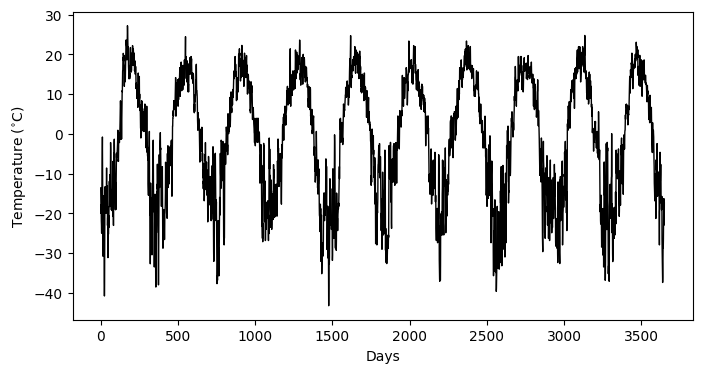

In [6]:
fig = plt.figure(figsize=(8,4))
plt.plot(temps, 'k-', linewidth=1)
plt.ylabel('Temperature ($^{\\circ}$C)')
plt.xlabel('Days')
plt.show()

Just as in our first notebook, let's build and remove a climatology to help in our model training:

In [7]:
climatology = np.zeros((365,))
for i in range(10):
    climatology += temps[i*365:(i+1)*365,0]
climatology /= 10

In [8]:
temps_anomaly = np.zeros_like(temps)
temps_clim = np.zeros_like(temps)
for i in range(10):
    temps_anomaly[i*365:(i+1)*365,0] = temps[i*365:(i+1)*365,0] - climatology
    temps_clim[i*365:(i+1)*365,0] = climatology

In [9]:
mean_temp = np.mean(temps_anomaly)
std_temp = np.std(temps_anomaly)
temps_anomaly_scaled = (temps_anomaly-mean_temp)/std_temp

As always, let's visualize our data to ensure it looks as expected:

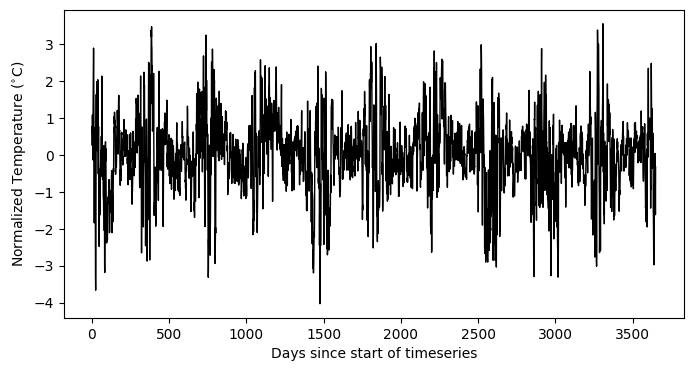

In [10]:
fig = plt.figure(figsize=(8,4))
plt.plot(temps_anomaly_scaled, 'k-', linewidth=1)
plt.ylabel('Normalized Temperature ($^{\\circ}$C)')
plt.xlabel('Days since start of timeseries')
plt.show()

## Preparing the training sequences

In this example, we're going to revisit the same question as explored previously, namely: **given a record of temperature over a given time period (e.g. 30 days), can we predict the next week of weather?**

To create this model, we'll need to create a set of sequences from our existing data and corresponding set of single temperatures for the next day:

In [11]:
# define the number of previous days to store in the sequence:
n_previous_days = 30
n_future_days = 7

# make sequences
X, y = [], []
for i in range(len(temps_anomaly_scaled) - n_previous_days-n_future_days):
    X.append(temps_anomaly_scaled[i:i+n_previous_days,0])       
    y.append(temps_anomaly_scaled[i+n_previous_days:i+n_previous_days+n_future_days,0])   
X = np.stack(X)
y = np.stack(y)
print(np.shape(X), np.shape(y))

(3613, 30) (3613, 7)


Again, we will use the first 8 year of our timeseries as the training data and the final two as the testing data:

In [12]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test   = X[split:], y[split:]

Finally, we'll need these to be PyTorch tensors and have a way to load these in our model, so let's convert these numpy arrays to tensors and make some `DataLoader` objects:

In [13]:
# convert to tensors
X_train_tensor = torch.tensor(X_train).float().unsqueeze(-1)
X_test_tensor = torch.tensor(X_test).float().unsqueeze(-1)
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()
print(X_test_tensor.shape)

# determine a batch size
batch_size = 16

# make a TensorDataset object for the training data
ds_train = TensorDataset(X_train_tensor, y_train_tensor)

# make a loader object for the training data
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=False)

# make a TensorDataset object for the training data
ds_test = TensorDataset(X_test_tensor, y_test_tensor)

# make a loader object for the training data
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

torch.Size([723, 30, 1])


## Building the LSTM Model

Let's take a look at a simple PyTorch implementation of an RNN with LSTM:

In [14]:
class TemperatureLSTM(nn.Module):
    def __init__(self, n_future_days, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, n_future_days)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

Here, we see that the `nn` module has an implementation of the LSTM mechanism built in - convenient! Let's see how our model performs

## Training the RNN with the LSTM

Training our new model is the same as our previous RNN example (and other PyTorch examples before that!). First, we make our model object:

In [15]:
model = TemperatureLSTM(n_future_days=7).to(device)

Then, we define our loss function and our gradient descent algorithm:

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

And we run a training loop:

In [17]:
EPOCHS = 20

# make empty arrays to keep track of the losses
train_losses = []
test_losses = []

# --- 4) Train ---
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)

    n_train, n_test = len(train_loader.dataset), len(test_loader.dataset)
    train_losses.append(train_loss/n_train)
    test_losses.append(test_loss/n_test)

    print(f"Epoch {epoch:03d} | train MSE: {train_loss/n_train:.6f} | test MSE: {test_loss/n_test:.6f}")


Epoch 001 | train MSE: 0.927418 | test MSE: 0.785630
Epoch 002 | train MSE: 0.834522 | test MSE: 0.760995
Epoch 003 | train MSE: 0.802116 | test MSE: 0.747474
Epoch 004 | train MSE: 0.785392 | test MSE: 0.740475
Epoch 005 | train MSE: 0.777537 | test MSE: 0.738492
Epoch 006 | train MSE: 0.774634 | test MSE: 0.738656
Epoch 007 | train MSE: 0.773481 | test MSE: 0.738986
Epoch 008 | train MSE: 0.772887 | test MSE: 0.739200
Epoch 009 | train MSE: 0.772510 | test MSE: 0.739329
Epoch 010 | train MSE: 0.772234 | test MSE: 0.739409
Epoch 011 | train MSE: 0.772009 | test MSE: 0.739461
Epoch 012 | train MSE: 0.771810 | test MSE: 0.739500
Epoch 013 | train MSE: 0.771625 | test MSE: 0.739536
Epoch 014 | train MSE: 0.771444 | test MSE: 0.739577
Epoch 015 | train MSE: 0.771260 | test MSE: 0.739636
Epoch 016 | train MSE: 0.771066 | test MSE: 0.739724
Epoch 017 | train MSE: 0.770854 | test MSE: 0.739852
Epoch 018 | train MSE: 0.770611 | test MSE: 0.740029
Epoch 019 | train MSE: 0.770330 | test MSE: 0.

Next, let's visualize our training and testing losses:

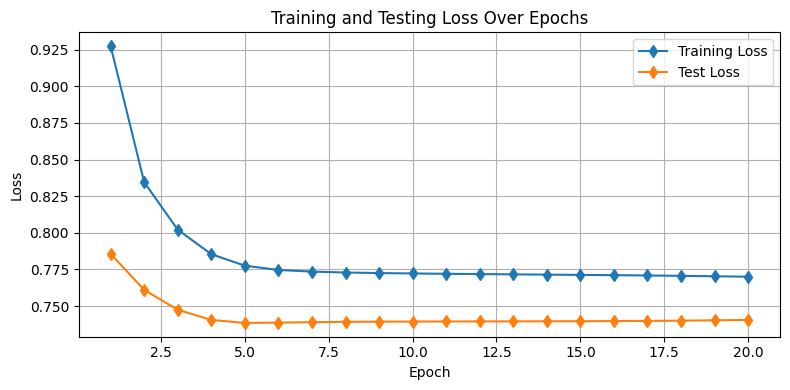

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Making Forecasts

As before, we can take a look at an example from our test set to see how our model is performing. Let's choose a random sample to make a forecast:

In [19]:
sample_index = 500

X_sample = X_test_tensor[sample_index,:].to(device).unsqueeze(0)
y_sample = y_test_tensor[sample_index,:].to(device).unsqueeze(0)

model.eval()
with torch.no_grad():
    forecast = model(X_sample)

Next, let's reconstruct our timeseries:

In [20]:
previous_temp_anom = X_sample.cpu().numpy().ravel()*std_temp+mean_temp  
future_temp_anom = y_sample.cpu().numpy().ravel()*std_temp+mean_temp  
forecast_temp_anom = forecast.cpu().numpy().ravel()*std_temp+mean_temp  

previous_temp = previous_temp_anom + temps_clim[split+sample_index:split+sample_index+n_previous_days,0]
future_temp = future_temp_anom + temps_clim[split+sample_index+n_previous_days:split+sample_index+n_previous_days+n_future_days,0]
forecast_temp = forecast_temp_anom + temps_clim[split+sample_index+n_previous_days:split+sample_index+n_previous_days+n_future_days,0]

And plot it:

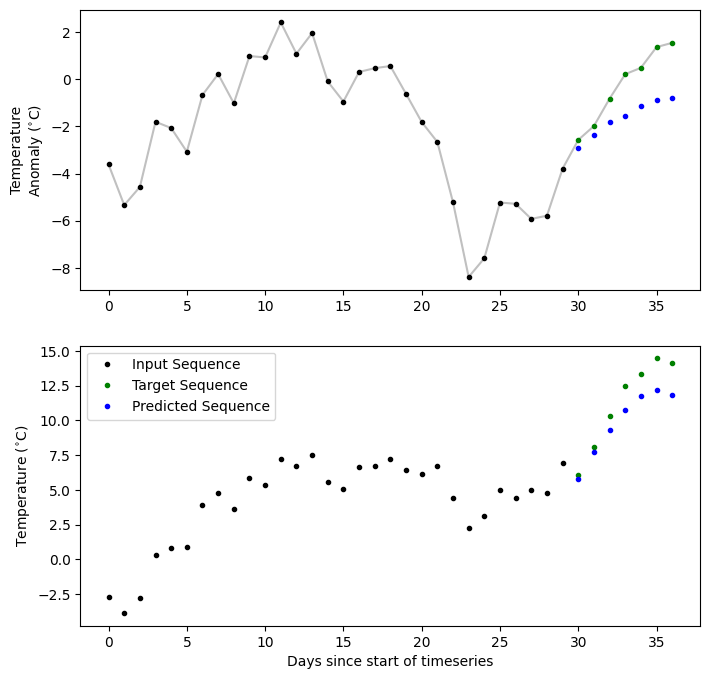

In [21]:
fig = plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.plot(np.concatenate([previous_temp_anom, future_temp_anom]),
          '-',color='silver',label='Raw')
plt.plot(np.arange(n_previous_days), previous_temp_anom,
         'k.', linewidth=1, label='Input Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         future_temp_anom, 'g.', label='Target Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         forecast_temp_anom, 'b.', label='Predicted Sequence')
plt.ylabel('Temperature\nAnomaly ($^{\\circ}$C)')

plt.subplot(2,1,2)
plt.plot(np.arange(n_previous_days), previous_temp,
         'k.', linewidth=1, label='Input Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         future_temp, 'g.', label='Target Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         forecast_temp, 'b.', label='Predicted Sequence')
plt.ylabel('Temperature ($^{\\circ}$C)')

plt.xlabel('Days since start of timeseries')
plt.legend()
plt.show()

We can also see if we can reconstruct the entire timeseries:

In [22]:
# make an an array of zeros to fill in with predicted values
predicted_temps_scaled = np.zeros((len(temps)-n_previous_days,))

# loop through the days to make a prediction
with torch.no_grad():
    for i in range(len(temps)-n_previous_days):
        sample_timeseries = temps_anomaly_scaled[i:i+n_previous_days]
        sample_timeseries = torch.tensor(sample_timeseries).float().unsqueeze(0).to(device)
        next_scaled = model(sample_timeseries).cpu().numpy()[0][0]
        predicted_temps_scaled[i] = next_scaled

Let's see our model is working:

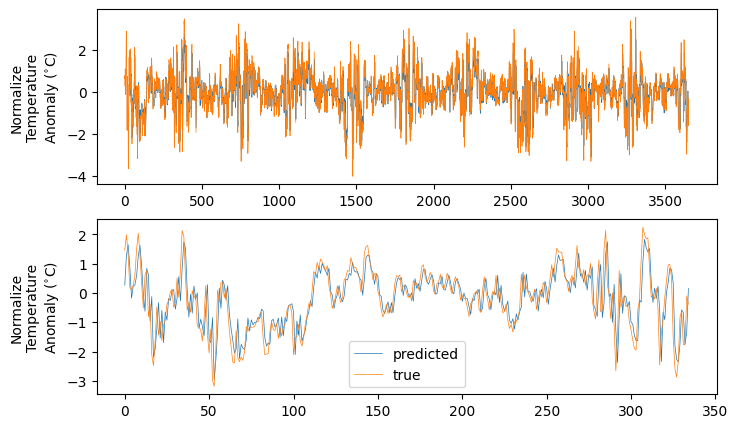

In [23]:
fig = plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(np.arange(n_previous_days, len(temps_anomaly_scaled)),
                   predicted_temps_scaled, linewidth=0.5, label='predicted')
plt.plot(temps_anomaly_scaled, linewidth=0.5, label='true')
plt.ylabel('Normalize\nTemperature\nAnomaly ($^{\\circ}$C)')

plt.subplot(2,1,2)
plt.plot(predicted_temps_scaled[:365-n_previous_days], linewidth=0.5, label='predicted')
plt.plot(temps_anomaly_scaled[n_previous_days:365], linewidth=0.5, label='true')
plt.ylabel('Normalize\nTemperature\nAnomaly ($^{\\circ}$C)')

plt.legend()
plt.show()

As we can see, the model works pretty well for predicting the temperature on a given day as long as we have the temperatures from the previous days.

### Other Examples
Curious to see more examples of an RNN in action? Check out chapter 15 in the textbook for this class (available on Canvas). There are two project examples:
- Sentiment analysis from IMDb movie reviews
- Language modeling at the character level

**Key Takeaways**
1. The Long Short Term Memory (LSTM) mechanisms replaces fully-connected linear layers in a standard neural network.
2. The LSTM mechanisms is implemented to avoid training issues associated with vanishing or exploding gradients.
3. For simple examples, results are similar to fully-connected layers; with more complex examples, the LSTM mechanism ensures long term dependencies are implemented in the memory of the network.